In [1]:
import scipy.io
import mne
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import spectrogram
from scipy.stats import entropy, skew
from scipy.linalg import toeplitz, cholesky
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder

D:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [9]:
# 1. 导入MAT文件
mat_data = scipy.io.loadmat('data/indy_20160407_02.mat')

In [10]:
# 提取数据
chan_names = mat_data['chan_names'].flatten()  #通道数96
chan_names=np.array([k[0] for k in chan_names])
cursor_pos = mat_data['cursor_pos']  #光标的位置
finger_pos = mat_data['finger_pos']  #指尖
spikes = mat_data['spikes']          #神经数据：unsorted/sorted
t = mat_data['t'].flatten()          #采样时间戳
target_pos = mat_data['target_pos']  #目标出现的xy
wf = mat_data['wf']                  #每个通道神经元发放波形

<class 'numpy.ndarray'> (48,)


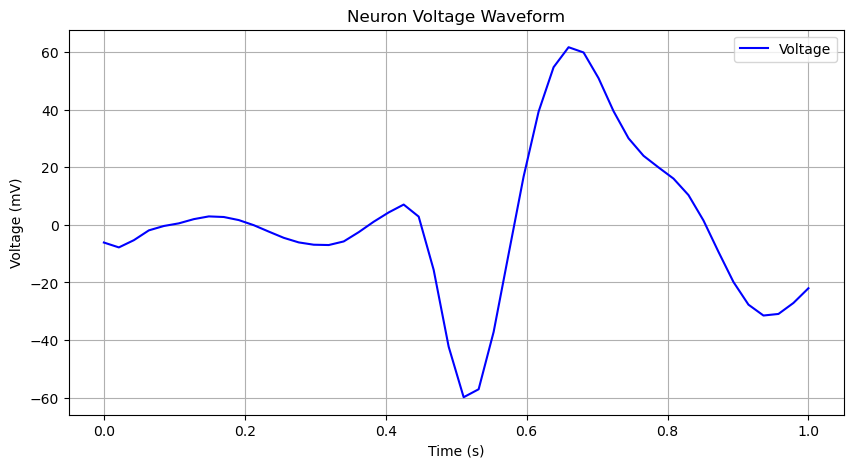

In [11]:

time = np.linspace(0, 1, 48)  # 生成从0到1秒的时间轴
voltage = wf[1,1][0,:]  # 生成示例的电压波形数据，这里使用正弦波形

print(type(voltage),voltage.shape)
# # 创建电压波形图
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, color='b', label='Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Neuron Voltage Waveform')
plt.legend()
plt.grid()
plt.show()


In [12]:
spike_times=spikes[0,0][:,:].flatten()
print(spike_times.shape)
hist, bins = np.histogram(spike_times, bins=np.arange(60.09, 887.7254, 5))
print(hist.shape)
a1=abs(target_pos[:,0]-cursor_pos[:,0])
a2=abs(target_pos[:,1]-cursor_pos[:,1])
print(a1)
print(hist[0:50])

(5595,)
(165,)
[146.48524279 146.48536261 146.48546325 ...   4.12780086   4.14532691
   4.16350982]
[38 32 33 25 22 42 25 33 38  6 40 20 24 26 20 22 50 51 24 39 30 21 34 14
 40 52 38 21 34 18 15 31 58 34 37 28 43 28 17 22 38 43 19 25 20 35 35 31
 29 23]


In [13]:
averages1 = []
averages2 = []
for i in range(0, len(a1), 1250):
    avg1 = np.mean(a1[i:i+1250])
    avg2 = np.mean(a2[i:i+1250])
    averages1.append(avg1)
    averages2.append(avg2)
print(len(averages1))

print(hist[8:826])

164
[ 38   6  40  20  24  26  20  22  50  51  24  39  30  21  34  14  40  52
  38  21  34  18  15  31  58  34  37  28  43  28  17  22  38  43  19  25
  20  35  35  31  29  23  26  18  31  19  31  25  47  38  28  35  49  34
  37  36  45  45  28  31  27  32  59  43  38  62  46  38  51  52  31  56
  19  24  43  39  61  36  37  63  43  30  30  37  27  32  68  12  53  33
  25  28  42  28  42  26  19  26  33  44  12  37  34  57  23  20  36  49
  31  19  25  13  63  35  23  30  60  33  25  25  26  30  28  15  37  13
  31  24  28  31  36  18  35  34  21  14  35  61  23  26  31 100  27  32
  13  51  31  47  24  29  36  78  26  11  75  60  42]


In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
# 使用numpy.vstack函数在行方向上连接两个自变量
X_combined = np.vstack((averages1, averages2)).T
print(X_combined.shape)
model = LinearRegression()

# 拟合模型
model.fit(X_combined,hist[0:164])


(164, 2)


LinearRegression()

In [15]:
y_pred = model.predict(X_combined)
from sklearn.metrics import r2_score
r_squared = r2_score(hist[0:164], y_pred)
print(y_pred[0:50])

[35.62614998 34.04048372 34.1599981  35.99708507 34.07603431 33.72798279
 33.00955923 33.33105689 34.32403671 33.31323564 33.89943674 34.17882695
 33.3327645  33.45683381 33.15066951 34.57951101 33.56201194 34.0422206
 32.85240289 33.71143895 34.17994883 34.19014909 33.34282764 33.44312457
 33.9293363  33.53656719 33.0293751  33.52117824 33.39095304 33.85372485
 33.9992208  34.3632236  33.96417859 34.26943959 33.50392008 33.7604118
 33.41144739 33.10586784 33.84478591 34.22729129 33.46993041 33.04816718
 33.7573482  33.80554817 34.21321502 34.84044659 33.26371889 33.73069182
 34.55052072 34.61656198]


In [16]:
print(r_squared)

0.0020637076171805546


In [17]:
spike_times=spikes[23,0][:,:].flatten()
print(spike_times.shape)
hist, bins = np.histogram(spike_times, bins=np.arange(60, 888, 5))
print(hist.shape)
a1=abs(target_pos[:,0]-cursor_pos[:,0])
a2=abs(target_pos[:,1]-cursor_pos[:,1])
averages1 = []
averages2 = []
for i in range(0, len(a1), 1250):
    avg1 = np.mean(a1[i:i+1250])
    avg2 = np.mean(a2[i:i+1250])
    averages1.append(avg1)
    averages2.append(avg2)
print(len(averages1))
import numpy as np
from sklearn.linear_model import LinearRegression
# 使用numpy.vstack函数在行方向上连接两个自变量
X_combined = np.vstack((averages1, averages2)).T
print(X_combined.shape)
model = LinearRegression()

# 拟合模型
model.fit(X_combined,hist[0:164])
y_pred = model.predict(X_combined)
from sklearn.metrics import r2_score
r_squared = r2_score(hist[0:164], y_pred)
print(y_pred[0:50])
print(r_squared)

(5472,)
(165,)
164
(164, 2)
[49.62159389 33.96451785 31.34443871 36.52368459 32.84047121 32.12820693
 31.24870397 32.80113811 33.24770613 32.06131935 32.09958248 35.30027201
 31.26884755 33.1433402  32.76945908 36.18570472 31.10976268 32.25592884
 30.77533911 34.49592974 32.72219281 34.23698845 31.36738671 29.73353325
 31.90382605 35.3225955  31.47272151 31.74412172 30.83947298 32.15681002
 32.04943247 33.86040365 33.0757782  33.21217932 34.77545318 34.03172847
 31.77478273 30.98317443 32.82309696 35.55136233 32.21556323 30.97431739
 33.21174692 32.88232115 33.74634134 33.91131397 29.53597359 30.971528
 35.16195003 33.94812621]
0.054166474092440686


In [18]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [19]:
kmeans = KMeans(n_clusters=3)

In [20]:
mat_data = scipy.io.loadmat('data/indy_20161006_02.mat')

In [24]:
concatenated_data = wf[0,0]
for j in range(1,96):
    concatenated_data = np.concatenate((concatenated_data, wf[j,0]), axis=0)

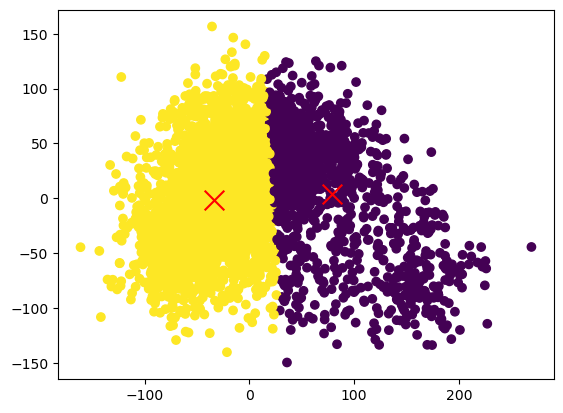

Silhouette Score: 0.53575975


In [54]:
from sklearn.metrics import silhouette_score
concatenated_data=wf[18,0]
pca = PCA(n_components=2)  # 将数据降到2维
reduced_data = pca.fit_transform(concatenated_data)

# 定义K-means模型
kmeans = KMeans(n_clusters=2) # 将数据分为2个簇

# 进行聚类
kmeans.fit(reduced_data)

# 获取聚类结果
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# 可视化聚类结果
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200)
plt.show()
from sklearn.metrics import silhouette_score
reduced_data1 = pca.fit_transform(wf[3,0])
labels = kmeans.predict(reduced_data1)
silhouette_avg = silhouette_score(reduced_data1, labels)
print("Silhouette Score:", silhouette_avg)

In [50]:
from sklearn.metrics import silhouette_score
reduced_data1 = pca.fit_transform(wf[4,1])
labels = kmeans.predict(reduced_data1)
silhouette_avg = silhouette_score(reduced_data1, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.5280308


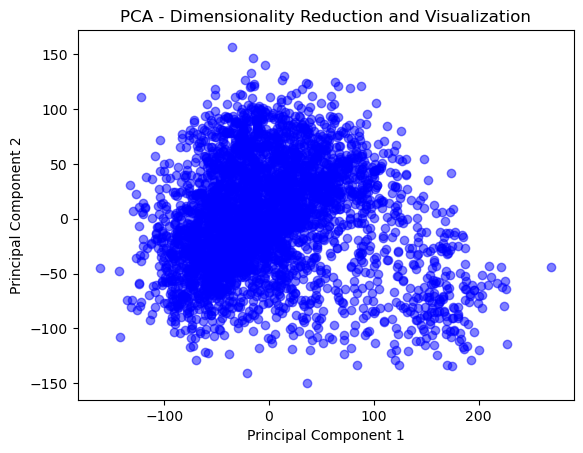

In [51]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='o', c='b', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Dimensionality Reduction and Visualization')
plt.show()